### Dataset
[1](https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
[2](http://vis-www.cs.umass.edu/lfw/)
[3](https://www.cs.tau.ac.il/~wolf/ytfaces/)


In [1]:
# login http://zeus.robots.ox.ac.uk/vgg_face2/ 
# !wget --header="Host: zeus.robots.ox.ac.uk" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.80 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9,th;q=0.8" --header="Cookie: _ga=GA1.3.1166372264.1545690704; _gid=GA1.3.1399545862.1546229647; vgg_usecookies=true; csrftoken=kqliwoJz6kQ8x3tHRuMo0PB6LTrgw0EbgvpLEfnK3CMuzQUxtlXd7q8CNxJRQQ7j; sessionid=cvpjnpqe3drx50g1ky7gbtf2jgjrxiq0" --header="Connection: keep-alive" "http://zeus.robots.ox.ac.uk/vgg_face2/get_file?fname=vggface2_test.tar.gz" -O "data/vggface2_test.tar.gz" -c    
# !tar -xzf data/vggface2_test.tar.gz -C data

# !wget --header="Host: zeus.robots.ox.ac.uk" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.80 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9,th;q=0.8" --header="Cookie: _ga=GA1.3.1166372264.1545690704; _gid=GA1.3.1399545862.1546229647; vgg_usecookies=true; csrftoken=kqliwoJz6kQ8x3tHRuMo0PB6LTrgw0EbgvpLEfnK3CMuzQUxtlXd7q8CNxJRQQ7j; sessionid=cvpjnpqe3drx50g1ky7gbtf2jgjrxiq0" --header="Connection: keep-alive" "http://zeus.robots.ox.ac.uk/vgg_face2/get_file?fname=vggface2_train.tar.gz" -O "data/vggface2_train.tar.gz" -c    
# !tar -xzf data/vggface2_train.tar.gz -C data


In [3]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import functools 
import operator 
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
from exitai.learner import Learner
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import os
class ImageFolderPath:
    '''
    - copy from https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
    - but doesn't check ext of files. Also unexpected folder in can led to error
    '''
    def __init__(self, dir):
        self.classes = []
        self.total_image = 0
        for target in sorted(os.listdir(dir)):
            d = os.path.join(dir, target)
            if not os.path.isdir(d):
                continue
            self.classes.append(d)
            self.total_image += len(os.listdir(d))

    def get_paths_image_by_class(self, class_path):
        paths_image = []
        for root, _, fnames in sorted(os.walk(class_path)): # I don't know why Pytorch using "for" here
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                paths_image.append(path)
        return paths_image


In [5]:
class VGGDataset(DataLoader):
    def __init__(self, root, transform):
        self.transform = transform
        self.image_folder = ImageFolderPath(root)
        
    def __getitem__(self, index):
        # anchor
        class_anchor = random.choice(list(self.image_folder.classes))
        paths_anchor = self.image_folder.get_paths_image_by_class(class_anchor)
        path_anchor = random.choice(paths_anchor)
        img_anchor = self.transform(Image.open(path_anchor))
        
        # positive
        path_pos = random.choice(paths_anchor)
        while path_pos is path_anchor:
            path_pos = random.choice(paths_anchor)
        img_pos = self.transform(Image.open(path_pos))
            
        # negative
        class_neg = random.choice(list(self.image_folder.classes))
        while class_neg is class_anchor:
            class_neg = random.choice(list(self.image_folder.classes))
        paths_neg = self.image_folder.get_paths_image_by_class(class_neg)
        path_neg = random.choice(paths_neg)
        img_neg = self.transform(Image.open(path_neg))
        
        return img_anchor, img_pos, img_neg
    
    def __len__(self):
        return self.image_folder.total_image

In [6]:
class ResizeSquareCenter(object):
    def __init__(self, square_size, interpolation=Image.BILINEAR):
        self.square_size = square_size
        self.interpolation = interpolation
        self.transform = transforms.CenterCrop((square_size, square_size))

    def __call__(self, img):
        old_size = img.size  # old_size[0] is in (width, height) format
        ratio = float(self.square_size)/min(old_size)
        new_size = tuple([round(x * ratio) for x in old_size])

        img = img.resize(new_size, resample=self.interpolation)
        return self.transform(img)

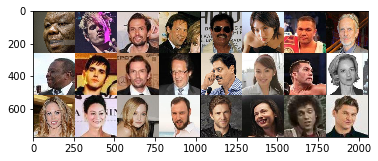

In [7]:
dataset_test = VGGDataset('data/test', transforms.Compose([
                                        ResizeSquareCenter(255),
                                        transforms.ToTensor()]))

data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=8)
example_batch = next(iter(data_loader_test))

concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
img = torchvision.utils.make_grid(concatenated)
img = img.numpy()

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

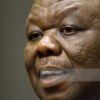

In [8]:
ResizeSquareCenter(100)(transforms.ToPILImage()(example_batch[0][0]))

In [9]:
# data = VGGDataset('data/test')
# resize = ResizeSquareCenter(100)
# columns = 8

# f = plt.figure(figsize=(10,10)) # total image size 
# for i in range(400, 600):
#     num = i%columns
#     sp = f.add_subplot(1, columns, num+1)
#     sp.axis('Off')
#     plt.imshow(resize(temp[i][0]))
    
#     if num is columns-1:
#         plt.pause(0.05)
#         f = plt.figure(figsize=(10,10))

### Create train data

In [10]:
transform_train = transforms.Compose([
                                   ResizeSquareCenter(255),
                                   transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
transform_test = transforms.Compose([
                                   ResizeSquareCenter(255),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])

dataset_train = VGGDataset('data/train', transform_train)
dataset_train.image_folder.total_image = 6400
dataset_test = VGGDataset('data/test', transform_test)
dataset_test.image_folder.total_image = 3200
data_loader_train = DataLoader(dataset_train, batch_size=64, shuffle=False, num_workers=0)
data_loader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=0)


### Model

In [11]:
from torchvision.models import resnet34

class FaceNetModel(nn.Module):
    def __init__(self, embedding_size, num_classes, pretrained=False):
        super (FaceNetModel, self).__init__()
        
        self.model            = resnet34(pretrained)
        self.embedding_size   = embedding_size
        self.model.fc         = nn.Linear(32768 , self.embedding_size) # 2048*3*3 = 18432
        self.model.classifier = nn.Linear(self.embedding_size, num_classes)
    
    
    def l2_norm(self, input):
        input_size = input.size()
        buffer     = torch.pow(input, 2)
        normp      = torch.sum(buffer, 1).add_(1e-10)
        norm       = torch.sqrt(normp)
        _output    = torch.div(input, norm.view(-1, 1).expand_as(input))
        output     = _output.view(input_size)
    
        return output
    
    
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        
        self.features = self.l2_norm(x)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha         = 10
        self.features = self.features*alpha
        
        return self.model.classifier(self.features)

In [12]:
class TripletLoss(nn.Module):
    
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        pos_dist   = F.pairwise_distance(anchor, positive)
        neg_dist   = F.pairwise_distance(anchor, negative)
        
        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min = 0.0)
        loss       = torch.mean(hinge_dist)
        return loss

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
margin = 0.2
criterion = TripletLoss(margin).to(device)
def model_loss_func(input_data, model, phase):
    input_anchor, input_positive, input_negative = input_data
    output_anchor = model(input_anchor)
    output_positive = model(input_positive)
    output_negative = model(input_negative)
    
    if phase=='train':
        # train only semi-hard
        distance_positive = F.pairwise_distance(output_anchor, output_positive)
        distance_negative = F.pairwise_distance(output_anchor, output_negative)
        mask_hard = distance_negative < distance_positive+margin
        num_hard = mask_hard.sum()
        if num_hard == 0:
            return 0, 0, 'skip' # if not semi-hard data, return the third params means skip update weight
        output_anchor = output_anchor[mask_hard]
        output_positive = output_positive[mask_hard]
        output_negative = output_negative[mask_hard]
        #-----------------------------------
    
    
    loss = criterion(output_anchor, output_positive, output_negative)
    return (output_anchor, output_positive, output_negative), loss

### Train
***BE CAREFUL***
The accuracy depends on threshold. Right now it's unreliable. We will find the best threshold later

In [14]:
# model = LeNetOneShot()
model = FaceNetModel(embedding_size=128, num_classes=10000)

def eval_func(input_data, output, loss):
    anchor, positive, negative = output
    positive_distance = F.pairwise_distance(anchor, positive)
    negative_distance = F.pairwise_distance(anchor, negative)
    return (positive_distance < negative_distance).sum().item()
learner = Learner(model, data_loader_train, data_loader_test)
learner.fit(model_loss_func, 0.002, num_epochs=100, eval_func=eval_func, early_stop='loss')

---- epoch:0 ------


RuntimeError: CUDA error: out of memory

In [19]:
# model = LeNetOneShot()
model = FaceNetModel(embedding_size=128, num_classes=10000)

def eval_func(input_data, output, loss):
    anchor, positive, negative = output
    positive_distance = F.pairwise_distance(anchor, positive)
    negative_distance = F.pairwise_distance(anchor, negative)
    return (positive_distance < negative_distance).sum().item()
learner = Learner(model, data_loader_train, data_loader_test)
learner.fit(model_loss_func, 0.002, num_epochs=100, eval_func=eval_func, early_stop='loss')

---- epoch:0 ------
   [train] Average loss: 0.7166, acc: 20.23%
   [test] Average loss: 0.2720, acc: 64.94%
---- epoch:1 ------
   [train] Average loss: 0.3964, acc: 28.25%
   [test] Average loss: 0.2314, acc: 68.34%
---- epoch:2 ------
   [train] Average loss: 0.4280, acc: 27.64%
   [test] Average loss: 0.2351, acc: 67.59%
---- epoch:3 ------
   [train] Average loss: 0.3499, acc: 32.86%
   [test] Average loss: 0.2046, acc: 71.50%
---- epoch:4 ------
   [train] Average loss: 0.3283, acc: 33.39%
   [test] Average loss: 0.1898, acc: 73.50%
---- epoch:5 ------
   [train] Average loss: 0.3135, acc: 34.19%
   [test] Average loss: 0.1881, acc: 74.44%
---- epoch:6 ------
   [train] Average loss: 0.3595, acc: 32.72%
   [test] Average loss: 0.2428, acc: 64.62%
---- epoch:7 ------
   [train] Average loss: 0.3435, acc: 32.98%
   [test] Average loss: 0.2087, acc: 70.56%
---- epoch:8 ------
   [train] Average loss: 0.3295, acc: 33.45%
   [test] Average loss: 0.2022, acc: 72.16%
---- epoch:9 ------

In [ ]:
learner.fit(model_loss_func, 0.002, num_epochs=100, eval_func=eval_func, early_stop='loss')

---- epoch:0 ------
   [train] Average loss: 0.3419, acc: 31.56%
   [test] Average loss: 0.1604, acc: 77.97%
---- epoch:1 ------
   [train] Average loss: 0.3021, acc: 29.06%
   [test] Average loss: 0.1414, acc: 80.59%
---- epoch:2 ------
   [train] Average loss: 0.3261, acc: 32.00%
   [test] Average loss: 0.1613, acc: 77.38%
---- epoch:3 ------
   [train] Average loss: 0.3177, acc: 28.94%
   [test] Average loss: 0.1512, acc: 79.22%
---- epoch:4 ------
   [train] Average loss: 0.3107, acc: 25.47%
   [test] Average loss: 0.1363, acc: 81.38%
---- epoch:5 ------
   [train] Average loss: 0.3125, acc: 23.58%
   [test] Average loss: 0.1252, acc: 83.28%
---- epoch:6 ------
   [train] Average loss: 0.3248, acc: 28.52%
   [test] Average loss: 0.1547, acc: 78.91%
---- epoch:7 ------
   [train] Average loss: 0.3149, acc: 28.98%
   [test] Average loss: 0.1599, acc: 77.50%
---- epoch:8 ------
   [train] Average loss: 0.3192, acc: 25.02%
   [test] Average loss: 0.1321, acc: 81.81%
---- epoch:9 ------

### Finding threshod

In [14]:
def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        positive_distance = F.pairwise_distance(anchor, positive)
        negative_distance = F.pairwise_distance(anchor, negative)
        return (positive_distance < negative_distance).sum().item()
learner.predict(model_loss_func, eval_func) 

   [test] Average loss: 0.2134, acc: 70.62%


In [15]:
def predict_with_threshold(threshold):
    def eval_func(input_data, output, loss):
        anchor, positive, negative = output
        
        # positive
        positive_distance = F.pairwise_distance(anchor, positive)
        positive_correct = positive_distance<threshold
        
        # negative
        negative_distance = F.pairwise_distance(anchor, negative)
        negative_correct = negative_distance>threshold
        return (positive_correct+negative_correct).sum().item()/2
    learner.predict(model_loss_func, eval_func)

In [16]:
for threshold in np.arange(0.2, 1, .1):
    print('threshold:', threshold)
    predict_with_threshold(threshold)

threshold: 0.2
   [test] Average loss: 0.2168, acc: 50.00%
threshold: 0.30000000000000004
   [test] Average loss: 0.2034, acc: 50.31%
threshold: 0.4000000000000001
   [test] Average loss: 0.2146, acc: 53.44%
threshold: 0.5000000000000001
   [test] Average loss: 0.1917, acc: 59.53%
threshold: 0.6000000000000001
   [test] Average loss: 0.1913, acc: 64.38%
threshold: 0.7000000000000002
   [test] Average loss: 0.2271, acc: 61.41%
threshold: 0.8000000000000003
   [test] Average loss: 0.2241, acc: 59.84%
threshold: 0.9000000000000001
   [test] Average loss: 0.2069, acc: 56.56%


In [17]:
predict_with_threshold(0.9)

   [test] Average loss: 0.2094, acc: 55.47%
